# 適応フィルタの比較：システム同定 (System Identification)

このノートブックでは、未知のシステム（フィルタ係数）をリアルタイムに推定する「システム同定」を通じて、代表的な適応アルゴリズムの性能を比較します。

## 入力信号の性質（白色 vs 有色）
適応アルゴリズムの性能は、入力信号の「自己相関（周波数特性の偏り）」に強く影響されます。
* **白色雑音 (White Noise):** すべての周波数が均等に含まれ、無相関。適応アルゴリズムにとって**最も簡単な条件**です。
* **有色雑音 (Colored Noise):** 低域や高域にエネルギーが偏り、強い相関を持つ信号（音声など）。誤差曲面が「歪んだ楕円体（谷）」になるため、**単純な勾配法では収束が極端に遅くなります**。

In [216]:
# @title 1. 信号の生成とパラメータ設定 { run: "auto" }
import numpy as np
import matplotlib.pyplot as plt

# --- 共通パラメータ ---
N_samples = 3000    # サンプル数
n_taps = 16         # フィルタのタップ数
noise_var = 0.01    # 観測ノイズの分散

# @markdown ### 🔽 入力信号の設定
input_type = "Colored Noise" # @param ["White Noise", "Colored Noise"]
# @markdown 有色信号の場合の相関の強さ（大きいほどLMSの収束が遅くなります）
ar_coef = 0.85 # @param {type:"slider", min:0.0, max:0.99, step:0.01}

np.random.seed(42)

# 未知システム（正解のフィルタ係数）
w_true = np.random.randn(n_taps)
w_true /= np.linalg.norm(w_true)

# 入力信号の生成
x_in = np.random.randn(N_samples)
if input_type == "Colored Noise":
    for i in range(1, N_samples):
        x_in[i] += ar_coef * x_in[i-1]

# 希望信号 d(n)
d = np.convolve(x_in, w_true, mode='full')[:N_samples]
d += np.sqrt(noise_var) * np.random.randn(N_samples)

print(f"入力信号: {input_type} (AR係数: {ar_coef if input_type == 'Colored Noise' else 'N/A'}) を生成しました。")

入力信号: Colored Noise (AR係数: 0.85) を生成しました。


## 1. LMS (Least Mean Squares)
パラメータ空間を平坦なユークリッド空間とみなし、平均二乗誤差の勾配（最急降下方向）へ進む最も基本的なアルゴリズムです。
$$\mathbf{w}(n+1) = \mathbf{w}(n) + \mu e(n) \mathbf{x}(n)$$
* **弱点:** 入力 $\mathbf{x}(n)$ のパワーに依存して更新量が変動するため、有色信号の歪んだ誤差曲面（細長い谷）ではジグザグに進み、収束が遅くなります。

In [217]:
def run_lms(x, d, n_taps, mu=0.01):
    N = len(x)
    w = np.zeros(n_taps)
    e = np.zeros(N)
    for n in range(n_taps, N):
        x_vec = x[n:n-n_taps:-1]
        y = np.dot(w, x_vec)
        e[n] = d[n] - y
        w += mu * e[n] * x_vec
    return e

## 2. NLMS (Normalized LMS)
LMSのステップサイズを、入力ベクトルのノルム（大きさ）で正規化した手法です。
$$\mathbf{w}(n+1) = \mathbf{w}(n) + \frac{\mu}{\|\mathbf{x}(n)\|^2 + \epsilon} e(n) \mathbf{x}(n)$$
* **幾何学的意味:** 誤差 $e(n)$ が直ちにゼロになるような「超平面」に対して、現在の重みベクトルから最短距離で**直交射影**します。入力のスケール変動に強くなります。

In [218]:
def run_nlms(x, d, n_taps, mu=0.5, eps=1e-6):
    N = len(x)
    w = np.zeros(n_taps)
    e = np.zeros(N)
    for n in range(n_taps, N):
        x_vec = x[n:n-n_taps:-1]
        y = np.dot(w, x_vec)
        e[n] = d[n] - y
        w += (mu / (np.dot(x_vec, x_vec) + eps)) * e[n] * x_vec
    return e

## 3. APA (Affine Projection Algorithm)
NLMSが「直近1サンプル」の部分空間へ射影するのに対し、APAは **「過去 $K$ サンプル」が張る部分空間へ同時にアフィン射影** するアルゴリズムです。
$$\mathbf{w}(n+1) = \mathbf{w}(n) + \mu \mathbf{X}(n) (\mathbf{X}^T(n) \mathbf{X}(n) + \epsilon \mathbf{I})^{-1} \mathbf{e}(n)$$
* ここで $\mathbf{X}(n)$ は過去 $K$ 回の入力ベクトルを並べた行列です。
* **特徴:** $K \times K$ の小さな逆行列計算が必要ですが、NLMS（$K=1$）よりもはるかに有色信号の相関を断ち切る能力が高く、高速に収束します。

In [219]:
def run_apa(x, d, n_taps, K=4, mu=0.5, eps=1e-6):
    N = len(x)
    w = np.zeros(n_taps)
    e_out = np.zeros(N)
    for n in range(n_taps + K, N):
        # 過去 K 回分の入力行列 X_mat と 希望信号 d_vec
        X_mat = np.zeros((n_taps, K))
        d_vec = np.zeros(K)
        for k in range(K):
            X_mat[:, k] = x[n-k : n-k-n_taps : -1]
            d_vec[k] = d[n-k]

        y_vec = X_mat.T @ w
        e_vec = d_vec - y_vec
        e_out[n] = e_vec[0] # 評価用には最新の誤差のみ保存

        # 射影行列の計算と更新
        R_mat = X_mat.T @ X_mat + eps * np.eye(K)
        w += mu * X_mat @ np.linalg.solve(R_mat, e_vec)
    return e_out

## 4. RLS (Recursive Least Squares)
過去すべての二乗誤差の重み付き和を最小化する最適解を、ニュートン法的に逐次更新します。
$$\mathbf{k}(n) = \frac{\mathbf{P}(n-1) \mathbf{x}(n)}{\lambda + \mathbf{x}^T(n) \mathbf{P}(n-1) \mathbf{x}(n)}$$
$$\mathbf{P}(n) = \lambda^{-1} \left( \mathbf{P}(n-1) - \mathbf{k}(n) \mathbf{x}^T(n) \mathbf{P}(n-1) \right)$$

* **情報幾何学からの解釈:** RLSが保持する行列 $\mathbf{P}(n)$ は、入力の自己相関行列 $\mathbf{R}$ の逆行列のオンライン推定値です。これは正規分布モデルにおいて **フィッシャー情報行列（Fisher Information Matrix）** の逆行列に相当します。
* つまり、RLSはパラメータ空間をリーマン多様体とみなし、**フィッシャー計量に基づく「自然勾配（Natural Gradient）」の方向に更新している**と解釈できます。空間の歪みを計量テンソルで完全に補正するため、有色信号でも最速で真の解へ到達します。

In [220]:
def run_rls(x, d, n_taps, lam=0.99, P_init=100.0):
    N = len(x)
    w = np.zeros(n_taps)
    e = np.zeros(N)
    P = P_init * np.eye(n_taps)
    for n in range(n_taps, N):
        x_vec = x[n:n-n_taps:-1]
        y = np.dot(w, x_vec)
        e[n] = d[n] - y

        # カルマンゲインと逆行列の更新
        pi_n = P @ x_vec
        k_n = pi_n / (lam + np.dot(x_vec, pi_n))
        w += k_n * e[n]
        P = (P - np.outer(k_n, pi_n)) / lam
    return e

## 学習曲線の比較 (Learning Curves)
各アルゴリズムを実行し、二乗誤差（MSE）の推移をデシベル（dB）でプロットします。

* **横軸:** サンプル数（時間の経過）
* **縦軸:** 誤差の大きさ（下に行くほど真のシステムに近づいている）
* **注目ポイント:** Step 1で「有色雑音」を選んだ場合、LMSの収束が劇的に遅くなり、NLMS $\rightarrow$ APA ($K=4$) $\rightarrow$ RLS の順に「過去の相関を補正する能力」が発揮されて収束が速くなる様子が確認できます。

Running simulations...


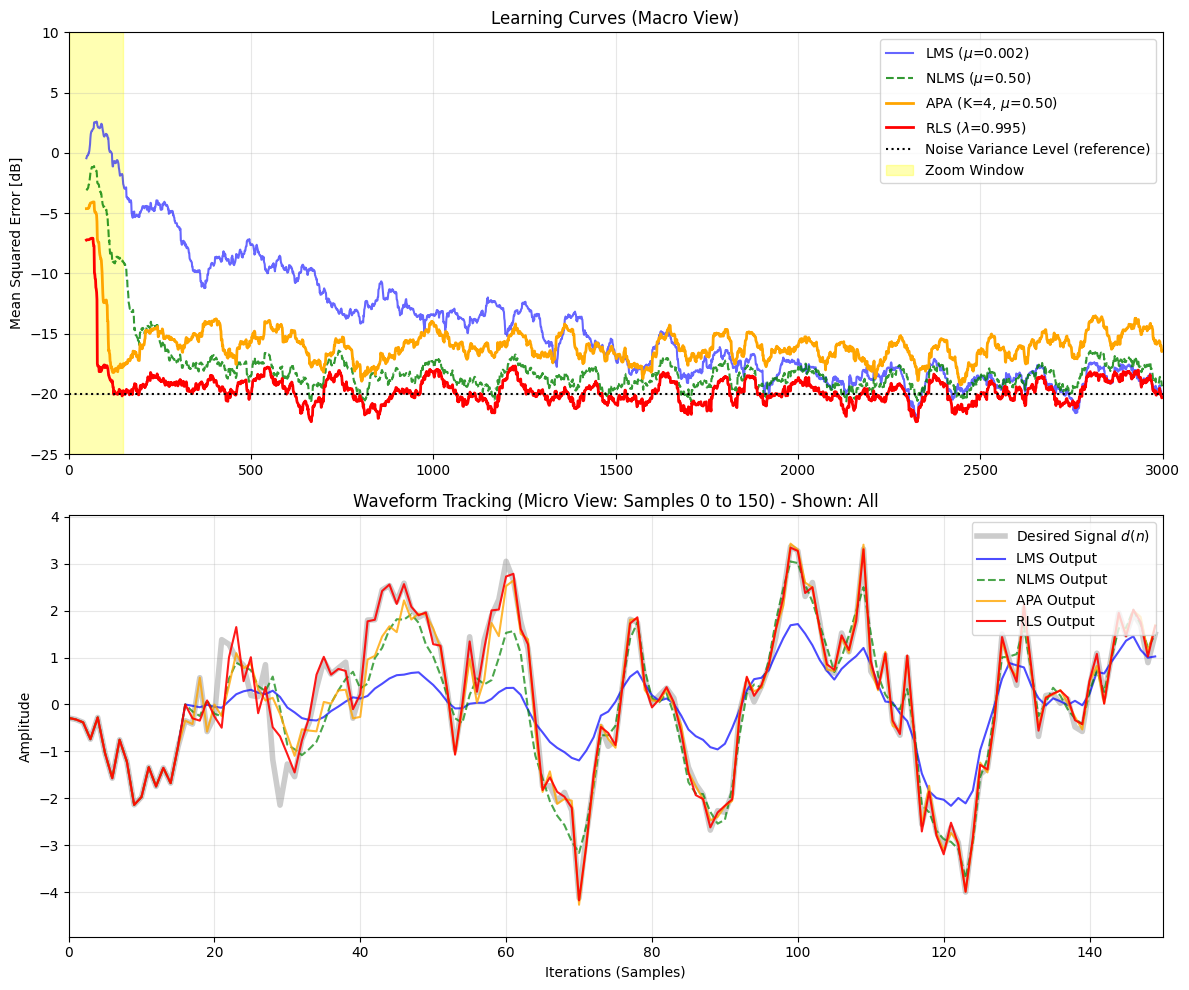

In [221]:
# @title 5. 性能比較の実行とグラフ描画 { run: "auto" }

# @markdown ### 🔽 Algorithm Parameters
# @markdown ---
mu_lms = 0.002  # @param {type:"slider", min:0.001, max:0.02, step:0.001}
mu_nlms = 0.5   # @param {type:"slider", min:0.05, max:1.5, step:0.05}
K_apa = 4       # @param {type:"slider", min:2, max:16, step:1}
mu_apa = 0.5    # @param {type:"slider", min:0.05, max:1.5, step:0.05}
lam_rls = 0.995 # @param {type:"slider", min:0.95, max:1.0, step:0.001}

# @markdown ---
# @markdown ### 🔍 Zoom Settings (for the bottom plot)
# @markdown Enter the start sample index for zooming
zoom_start_sample = 0  # @param {type:"integer"}
# @markdown Select which algorithms to display in the micro-view
display_algo = "All"  # @param ["LMS", "NLMS", "APA", "RLS", "All"]

zoom_width = 150

print("Running simulations...")

# --- Run algorithms ---
e_lms = run_lms(x_in, d, n_taps, mu=mu_lms)
e_nlms = run_nlms(x_in, d, n_taps, mu=mu_nlms)
e_apa = run_apa(x_in, d, n_taps, K=K_apa, mu=mu_apa)
e_rls = run_rls(x_in, d, n_taps, lam=lam_rls)

# --- Handle the initial region (where filter output is not well-defined) ---
# Using d[:] here makes the early MSE artificially large and confusing.
# For visualization, set it to 0 so that learning curves reflect the actual adaptation region.
e_lms[:n_taps] = 0.0
e_nlms[:n_taps] = 0.0
e_apa[:n_taps + K_apa] = 0.0
e_rls[:n_taps] = 0.0

def smooth_mse_with_index(e, window=50):
    """
    Moving-average smoothed MSE with correct sample index alignment.

    mode='valid' shortens the sequence by (window-1), so we return the
    corresponding x-axis indices as well.
    """
    mse = e**2
    sm = np.convolve(mse, np.ones(window) / window, mode='valid')
    idx = np.arange(window - 1, window - 1 + len(sm))
    return idx, sm

# --- Plotting (Macro + Micro) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# [Top] Learning Curves (Macro View)
idx_lms, mse_lms = smooth_mse_with_index(e_lms)
idx_nlms, mse_nlms = smooth_mse_with_index(e_nlms)
idx_apa, mse_apa = smooth_mse_with_index(e_apa)
idx_rls, mse_rls = smooth_mse_with_index(e_rls)

ax1.plot(idx_lms, 10 * np.log10(mse_lms + 1e-10),
         label=rf'LMS ($\mu$={mu_lms:.3f})', color='blue', alpha=0.6, linestyle='-')
ax1.plot(idx_nlms, 10 * np.log10(mse_nlms + 1e-10),
         label=rf'NLMS ($\mu$={mu_nlms:.2f})', color='green', alpha=0.8, linestyle='--')
ax1.plot(idx_apa, 10 * np.log10(mse_apa + 1e-10),
         label=rf'APA (K={K_apa}, $\mu$={mu_apa:.2f})', color='orange', linewidth=2)
ax1.plot(idx_rls, 10 * np.log10(mse_rls + 1e-10),
         label=rf'RLS ($\lambda$={lam_rls:.3f})', color='red', linewidth=2)

# Noise floor line (if defined in earlier cells)
noise_floor_dB = 10 * np.log10(noise_var)
ax1.axhline(noise_floor_dB, color='black', linestyle=':', label='Noise Variance Level (reference)')

# Zoom window bounds (safe clipping)
max_start_idx = max(0, N_samples - zoom_width)
zoom_start_safe = min(max(0, zoom_start_sample), max_start_idx)
zoom_end = min(zoom_start_safe + zoom_width, N_samples)

# Draw zoom region
ax1.axvspan(zoom_start_safe, zoom_end, color='yellow', alpha=0.3, label='Zoom Window')

ax1.set_title('Learning Curves (Macro View)')
ax1.set_ylabel('Mean Squared Error [dB]')
ax1.set_xlim([0, N_samples])
ax1.set_ylim([noise_floor_dB - 5, 10])
ax1.legend(loc='upper right')
ax1.grid(True, which="both", ls="-", alpha=0.3)

# [Bottom] Waveform Tracking (Micro View)
time_axis = np.arange(zoom_start_safe, zoom_end)

# Reconstruct outputs (y = d - e)
y_lms = d - e_lms
y_nlms = d - e_nlms
y_apa = d - e_apa
y_rls = d - e_rls

# Desired signal (background)
ax2.plot(time_axis, d[zoom_start_safe:zoom_end],
         label='Desired Signal $d(n)$', color='gray', alpha=0.4, linewidth=4)

# Plot selected outputs
if display_algo in ["LMS", "All"]:
    ax2.plot(time_axis, y_lms[zoom_start_safe:zoom_end],
             label='LMS Output', color='blue', alpha=0.7, linewidth=1.5)
if display_algo in ["NLMS", "All"]:
    ax2.plot(time_axis, y_nlms[zoom_start_safe:zoom_end],
             label='NLMS Output', color='green', alpha=0.7, linewidth=1.5, linestyle='--')
if display_algo in ["APA", "All"]:
    ax2.plot(time_axis, y_apa[zoom_start_safe:zoom_end],
             label='APA Output', color='orange', alpha=0.8, linewidth=1.5)
if display_algo in ["RLS", "All"]:
    ax2.plot(time_axis, y_rls[zoom_start_safe:zoom_end],
             label='RLS Output', color='red', alpha=0.9, linewidth=1.5)

ax2.set_title(f'Waveform Tracking (Micro View: Samples {zoom_start_safe} to {zoom_end}) - Shown: {display_algo}')
ax2.set_xlabel('Iterations (Samples)')
ax2.set_ylabel('Amplitude')
ax2.set_xlim([zoom_start_safe, zoom_end])

amp_margin = 1.2
y_min = amp_margin * np.min(d[zoom_start_safe:zoom_end])
y_max = amp_margin * np.max(d[zoom_start_safe:zoom_end])
ax2.set_ylim([y_min, y_max])
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>